In [ ]:
!conda activate ./.conda

In [ ]:
!conda install -y -c pandas

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torch import nn #API for building neural networks
from torch.utils.data import Dataset, DataLoader #Imports the Dataset and Dataloader classes
import os

### Audio data
I will use the audio MNIST dataset to demonstrate how to use audio data with PyTorch.  
The first thing I must do is create the annotations files for training and testing.

    # With this code I have built a list with all the annotations.

    import os

    path = '../input/audio-mnist/data/'
    annot_list = []
    for folder in os.listdir(path):
        if os.path.isdir(path + '/' + folder):
            for file in os.listdir(path + '/' + folder):  
                file_path = path + '/' + folder + '/' + file
                label = file[0]
                annot_list.append((file_path, label))
    # Although the os.listdir does not follow any apparent order, I will shuffle it just to be safe.

    import random
    random.shuffle(annot_list)

    # Split in train and test

    train_size = int(0.75*len(annot_list))
    train_list = annot_list[:train_size]
    test_list = annot_list[train_size:]

    # Finally created the annnotations file

    import csv

    with open('train_audioMNIST.csv', mode='w') as csv_file:  
        csv_writer = csv.writer(csv_file)
        for item in train_list:
            csv_writer.writerow([item[0], item[1]])  

    with open('test_audioMNIT.csv', mode='w') as csv_file:  
        csv_writer = csv.writer(csv_file)
        for item in test_list:
            csv_writer.writerow([item[0], item[1]]) 

Now I must create a dataset with the data.  
PyTorch provides an API for converting audio files to Tensors, torchaudio.

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device)) #Use GPU if available

Using cpu device


In [5]:
import torchaudio

class AudioDataset(Dataset):
    def __init__(self, annotations_file):
        self.annotations = pd.read_csv(annotations_file, header=None, 
                               names=['Path', 'Label'], delimiter=',')
        
    def __len__(self):
        return(len(self.annotations))
    
    def __getitem__(self, index):
        audio = torchaudio.load(self.annotations['Path'][index])
        label = self.annotations['Label'][index]
        return(audio[0][0], label)

6


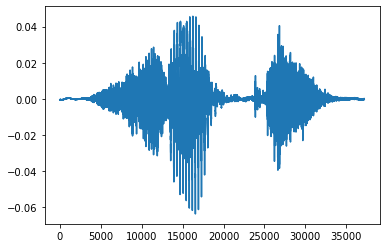

In [4]:
audioMNIST_train = AudioDataset('../input/audiomnistannot/train_audioMNIST.csv')
audioMNIST_test = AudioDataset('../input/audiomnistannot/test_audioMNIT.csv')
audio, label = next(iter(audioMNIST_train))
import matplotlib.pyplot as plt
%matplotlib inline
print(label)
plt.plot(audio.numpy())
plt.show()

In [5]:
for i in range(20):
    print(len(audioMNIST_train[i][0]))

37199
22954
36933
27313
30253
34069
26619
22617
28424
30849
42292
25569
43383
38051
37600
45805
31889
37362
34469
21106


This will return the raw audio data as a tensor. Although it is possible to use the raw data to train a neural network, a more common approach is to apply convolutional neural networks to the spectogram of the audio, so we will return the spectogram instead.  
Also, we need to have all the audios to have the same length to make the spectrograms all the same size, so we will zero pad all the audios until they reach the desired length. Since the audios have less than 1s in length, we will zero pad them so they all have 1s second.

In [6]:
class AudioDatasetSpectrogram(Dataset):
    def __init__(self, annotations_file, ToSpectrogram, ToDB):
        self.annotations = pd.read_csv(annotations_file, header=None, 
                               names=['Path', 'Label'], delimiter=',')
        self.ToSpectrogram = ToSpectrogram
        self.ToDB = ToDB
        
    def __len__(self):
        return(len(self.annotations))
    
    def __getitem__(self, index):
        audio_padded = torch.zeros((1,48000))
        audio = torchaudio.load(self.annotations.iloc[index, 0])
        audio_padded[0,:len(audio[0][0])] = audio[0][0]
        label = self.annotations.iloc[index, 1]
        spectrogram = self.ToSpectrogram(audio_padded)
        spectrogram = self.ToDB(spectrogram)
        return(spectrogram, label)

In [7]:
ToSpectrogram = torchaudio.transforms.MelSpectrogram()
ToDB = torchaudio.transforms.AmplitudeToDB()
train_dataset = AudioDatasetSpectrogram('../input/audiomnistannot/train_audioMNIST.csv', ToSpectrogram, ToDB)
test_dataset = AudioDatasetSpectrogram('../input/audiomnistannot/test_audioMNIT.csv', ToSpectrogram, ToDB)

/opt/conda/lib/python3.7/site-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


torch.Size([1, 128, 241])


/opt/conda/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/opt/conda/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


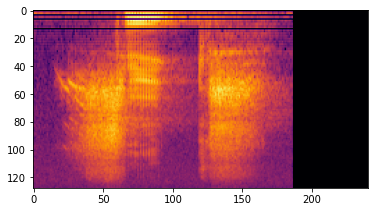

In [8]:
spectrogram, label = next(iter(train_dataset))
print(spectrogram.shape)
plt.imshow(spectrogram[0], cmap='inferno')

In [9]:
train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True, num_workers=10)
test_loader = DataLoader(test_dataset, batch_size=500, shuffle=True, num_workers=10)

Before building the model I will calculate the mean, so we can zero mean the data.

In [10]:
temp_img = 0
for img, label in train_loader:
    temp_img += img.mean(dim=0)
div = len(train_dataset)/train_loader.batch_size
mean_img = (temp_img/div).float().to(device)

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.ConvNet = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=7, stride=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(38*19*10, 10)
        )
        
    def forward(self, x):
        logits = self.ConvNet(x)
        return(logits)

In [12]:
model = CNN().to(device)
print(model)

CNN(
  (ConvNet): Sequential(
    (0): Conv2d(1, 10, kernel_size=(7, 7), stride=(3, 3))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(5, 5), stride=(2, 2))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=7220, out_features=10, bias=True)
  )
)


In [13]:
model_loss = nn.CrossEntropyLoss()
model_optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [14]:
def train_model(model, dataloader, model_loss, optimizer, device, mean=0):
    total_loss = 0
    total_correct = 0
    model.train() # Specifies that the model should compute gradients
    for X, y in dataloader:
        #Zero mean and transfer data to device
        X = X.to(device)
        X = X - mean
        y = y.to(device)
        # Forward pass
        prediction = model(X)
        loss = model_loss(prediction, y.long())
        # Update loss and score
        total_loss += loss.item()
        total_correct += (prediction.argmax(1)==y).sum().item()
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    size = len(dataloader.dataset)
    avg_loss = loss/size
    score = total_correct/size
    return(avg_loss, score)

def test_model(model, dataloader, model_loss, device, mean=0):
    total_loss = 0
    total_correct = 0
    model.eval() #Specifies that the model does not need to keep track of gradients
    for X, y in dataloader:
        X = X.to(device)
        X = X - mean
        y = y.to(device)
        prediction = model(X)
        loss = model_loss(prediction, y.long())
        total_loss += loss.item()
        total_correct += (prediction.argmax(1) == y).sum().item()
        
    size = len(dataloader.dataset)
    avg_loss = total_loss/size
    score = total_correct/size
    return(avg_loss, score)

In [15]:
train_losses, train_scores, test_losses, test_scores = [], [], [], []
for epoch in range(30):
    print('Epoch:', epoch)
    train_loss, train_score = train_model(model, train_loader, model_loss, model_optimizer, device, mean_img)
    test_loss, test_score = test_model(model, test_loader, model_loss, device, mean_img)
    train_losses.append(train_loss)
    train_scores.append(train_score)
    test_losses.append(test_loss)
    test_scores.append(test_score)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29


Final test score:  0.9928


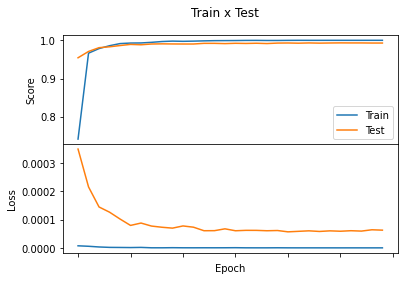

In [16]:
#Plot the train and test errors and losses
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,1, sharex=True)
axs[0].plot(train_scores, label='Train')
axs[0].plot(test_scores, label='Test')
axs[0].legend(loc='lower right')
axs[0].set_ylabel('Score')
axs[1].plot(train_losses)
axs[1].plot(test_losses)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
fig.suptitle('Train x Test')
fig.subplots_adjust(hspace = .001)
axs[0].set_xticklabels(())
axs[0].title.set_visible(False)
plt.plot()
print('Final test score: ', test_scores[-1])